<a href="https://colab.research.google.com/github/sagawritescode/ENDTwoPointOPhase1/blob/main/ERA_V1_Assignment_8_Group_Normalisation_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [28]:
%matplotlib inline

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms

Data Download and Transformations

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Inspect the dataset

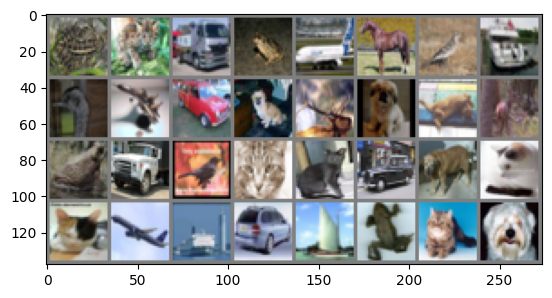

frog  cat   truck frog  plane horse bird  ship  bird  plane car   dog   deer  dog   cat   deer  frog  truck bird  cat   cat   car   dog   cat   cat   plane ship  car   ship  frog  cat   dog  


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Model Initialisation and Summary

In [32]:
!pip install torchsummary
from torchsummary import summary
from model import GroupNormalisationModel
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = GroupNormalisationModel(16).to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             512
        MaxPool2d-10           [-1, 16, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           2,304
             ReLU-12           [-1, 16, 17, 17]               0

Define Train and Test Functions

In [33]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    iterator_count = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_comparisons = pred.eq(target.view_as(pred))
            correct += pred_comparisons.sum().item()

            ## code to store misclassfied images
            predictions = pred_comparisons.squeeze()
            pred = pred.squeeze()
            target = (target.view_as(pred)).squeeze()
            index = 0
            if len(misclassified_images) < 10:
                for prediction in predictions:
                    if prediction.item() is False:

                        misclassified_images.append((data[index], pred[index].item(), target[index].item()))
                        break
                    index += 1

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Learning (And Simultaneous Evaluation) Begins!

In [34]:
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.1145907640457153 Batch_id=1562 Accuracy=38.77: 100%|██████████| 1563/1563 [00:22<00:00, 68.25it/s]



Test set: Average loss: 1.3503, Accuracy: 5131/10000 (51.31%)

EPOCH: 1


Loss=0.9201194047927856 Batch_id=1562 Accuracy=54.40: 100%|██████████| 1563/1563 [00:19<00:00, 80.28it/s]



Test set: Average loss: 1.1039, Accuracy: 6057/10000 (60.57%)

EPOCH: 2


Loss=1.0311799049377441 Batch_id=1562 Accuracy=60.15: 100%|██████████| 1563/1563 [00:19<00:00, 81.84it/s]



Test set: Average loss: 1.0172, Accuracy: 6353/10000 (63.53%)

EPOCH: 3


Loss=0.9415917992591858 Batch_id=1562 Accuracy=64.09: 100%|██████████| 1563/1563 [00:19<00:00, 79.02it/s]



Test set: Average loss: 0.9706, Accuracy: 6614/10000 (66.14%)

EPOCH: 4


Loss=0.7079964876174927 Batch_id=1562 Accuracy=66.67: 100%|██████████| 1563/1563 [00:19<00:00, 82.04it/s]



Test set: Average loss: 0.8998, Accuracy: 6853/10000 (68.53%)

EPOCH: 5


Loss=0.9718522429466248 Batch_id=1562 Accuracy=68.75: 100%|██████████| 1563/1563 [00:18<00:00, 82.42it/s]



Test set: Average loss: 0.8685, Accuracy: 6981/10000 (69.81%)

EPOCH: 6


Loss=0.7102633118629456 Batch_id=1562 Accuracy=72.84: 100%|██████████| 1563/1563 [00:19<00:00, 81.32it/s]



Test set: Average loss: 0.7703, Accuracy: 7294/10000 (72.94%)

EPOCH: 7


Loss=0.6900599002838135 Batch_id=1562 Accuracy=73.60: 100%|██████████| 1563/1563 [00:18<00:00, 82.93it/s]



Test set: Average loss: 0.7644, Accuracy: 7308/10000 (73.08%)

EPOCH: 8


Loss=0.7343798875808716 Batch_id=1562 Accuracy=74.04: 100%|██████████| 1563/1563 [00:18<00:00, 83.26it/s]



Test set: Average loss: 0.7652, Accuracy: 7343/10000 (73.43%)

EPOCH: 9


Loss=0.5663001537322998 Batch_id=1562 Accuracy=74.04: 100%|██████████| 1563/1563 [00:18<00:00, 84.16it/s]



Test set: Average loss: 0.7531, Accuracy: 7341/10000 (73.41%)

EPOCH: 10


Loss=0.4860192537307739 Batch_id=1562 Accuracy=74.40: 100%|██████████| 1563/1563 [00:18<00:00, 84.16it/s]



Test set: Average loss: 0.7442, Accuracy: 7416/10000 (74.16%)

EPOCH: 11


Loss=0.452650785446167 Batch_id=1562 Accuracy=74.67: 100%|██████████| 1563/1563 [00:19<00:00, 82.12it/s]



Test set: Average loss: 0.7539, Accuracy: 7378/10000 (73.78%)

EPOCH: 12


Loss=0.7899695634841919 Batch_id=1562 Accuracy=75.37: 100%|██████████| 1563/1563 [00:18<00:00, 82.49it/s]



Test set: Average loss: 0.7433, Accuracy: 7387/10000 (73.87%)

EPOCH: 13


Loss=0.80788254737854 Batch_id=1562 Accuracy=75.28: 100%|██████████| 1563/1563 [00:18<00:00, 82.65it/s]



Test set: Average loss: 0.7397, Accuracy: 7390/10000 (73.90%)

EPOCH: 14


Loss=0.514378547668457 Batch_id=1562 Accuracy=75.40: 100%|██████████| 1563/1563 [00:18<00:00, 83.82it/s]



Test set: Average loss: 0.7401, Accuracy: 7407/10000 (74.07%)



Display misclassified images

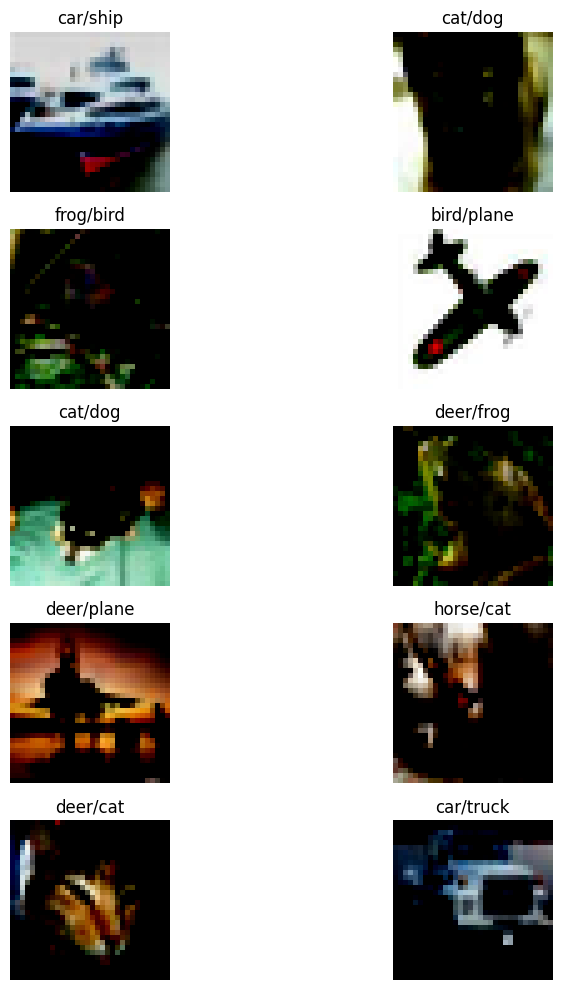

In [35]:
def denormalise_image(normalized_image):
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))

    # Denormalize the image
    denormalized_image = denormalize(normalized_image)

    # Convert the tensor to a numpy array
    denormalized_image = denormalized_image.cpu().numpy()

    # Convert the image from range [-1, 1] to [0, 1]
    denormalized_image = (denormalized_image + 1) / 2

    return denormalized_image

denormalised_images = []
for image, pred, target in misclassified_images:
    denormalised_images.append((denormalise_image(image), pred, target))


fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        misclassified_image = misclassified_images[i * 2 + j]
        image = misclassified_image[0].cpu().numpy()
        axes[i, j].imshow(np.transpose(image, (1, 2, 0)))
        axes[i, j].axis('off')

        axes[i, j].set_title(f'{classes[misclassified_image[1]]}/{classes[misclassified_image[2]]}')
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Test Accuracy')

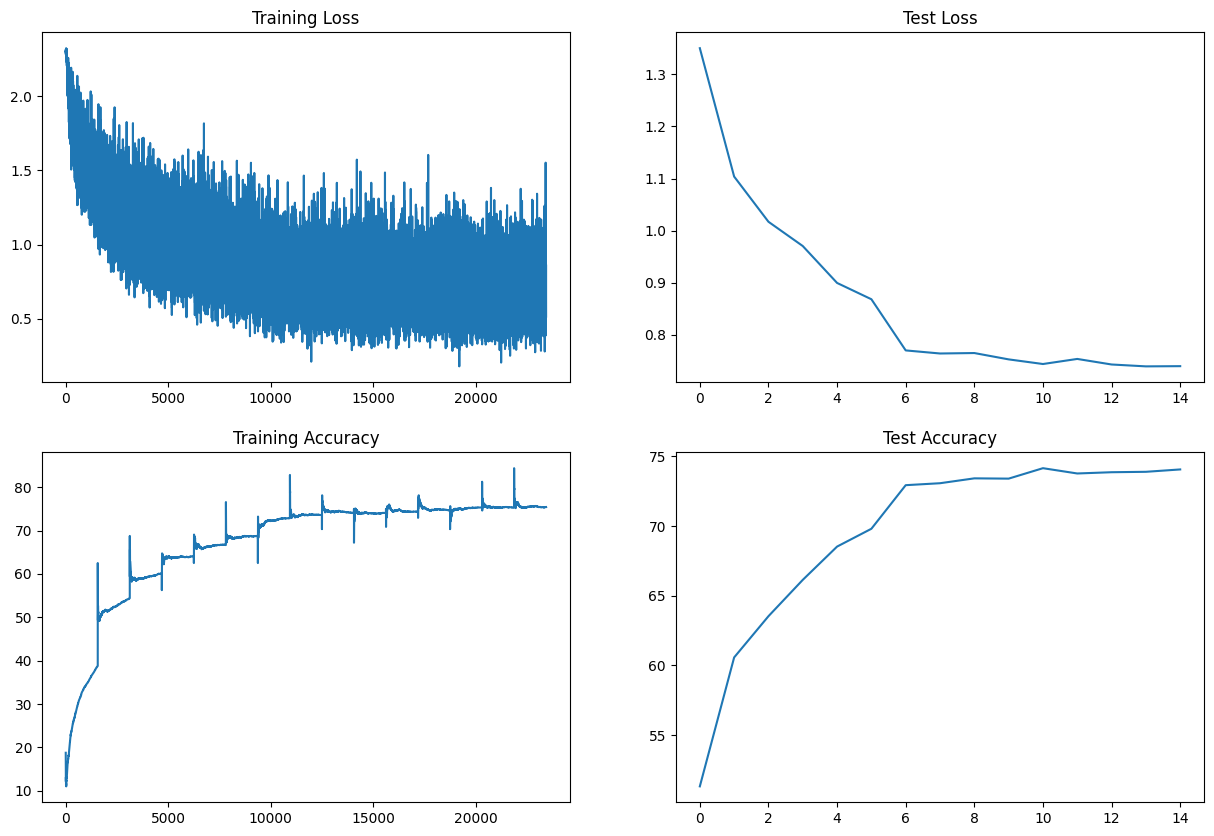

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
print(type(axs))
t = [t_items.item() for t_items in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")